1. Imports and Dataset Loading

In [2]:
import os
import seaborn as sns
import numpy as np
from PIL import Image, UnidentifiedImageError, ImageFile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

ImageFile.LOAD_TRUNCATED_IMAGES = True  # Allow truncated images to load

# Function to load images
def load_images_from_folder(folder):
    images = []
    labels = []
    image_shape = (224, 224)  # Define the desired shape for resizing
    for class_name in os.listdir(folder):
        class_path = os.path.join(folder, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                try:
                    # Handle different image formats and issues
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        img = Image.open(img_path).convert('RGB').resize(image_shape)  # Convert to RGB
                        img = np.array(img)
                        if img.shape == (224, 224, 3):  # Ensure image has correct shape (RGB)
                            images.append(img)
                            labels.append(class_name)
                        else:
                            print(f"Skipping image {img_path} due to incorrect shape: {img.shape}")
                    else:
                        print(f"Skipping non-supported image {img_path}")
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")
    if not images or not labels:
        raise ValueError("No valid images found in the dataset path")
    return np.array(images), np.array(labels)

# Load the dataset
dataset_path = r'C:\Users\IZZAT\Downloads\ISB46703 - PRINCIPLES OF ARTIFICIAL INTELLIGENCE\Mini Project Horse\Mini Project Horse\Mini Project\dataset'
X, y = load_images_from_folder(dataset_path)

# Calculate unique classes and their counts
unique_classes, class_counts = np.unique(y, return_counts=True)

# Print total number of images and total number of classes
print(f"Total number of images: {len(X)}")
print(f"Total number of classes: {len(unique_classes)}")
print("Class distribution:")
for class_name, count in zip(unique_classes, class_counts):
    print(f"{class_name}: {count} images")

# Convert labels to one-hot encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)
y = tf.keras.utils.to_categorical(y)

# Split the dataset
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Normalize images
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0



c:\Users\IZZAT\anaconda3\envs\ISB46703\lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Total number of images: 5026
Total number of classes: 5
Class distribution:
Arabian Horse: 1000 images
Haflinger Horse: 1002 images
Icelandic Horse: 1000 images
Jutland Horse: 1012 images
Knabstrupper Horse: 1012 images


2. Data Augmentation and Generators

In [3]:
# Data generators
train_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = ImageDataGenerator().flow(X_val, y_val, batch_size=32)
test_generator = ImageDataGenerator().flow(X_test, y_test, batch_size=32)


3. Model Definition and Training

In [4]:
# Load ResNet50 model without the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add new top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(le.classes_), activation='softmax')(x)

# Compile the model
model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
start_time = time.time()
history = model.fit(train_generator, validation_data=val_generator, epochs=50)
training_time = time.time() - start_time

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)

94765736/94765736 [==============================] - 12s 0us/step
Epoch 1/50
95/95 [==============================] - 157s 2s/step - loss: 1.6665 - accuracy: 0.2667 - val_loss: 1.5756 - val_accuracy: 0.3294
Epoch 2/50
95/95 [==============================] - 160s 2s/step - loss: 1.5210 - accuracy: 0.3383 - val_loss: 1.4787 - val_accuracy: 0.3224
Epoch 3/50
95/95 [==============================] - 165s 2s/step - loss: 1.4609 - accuracy: 0.3728 - val_loss: 1.3688 - val_accuracy: 0.4557
Epoch 4/50
95/95 [==============================] - 191s 2s/step - loss: 1.4415 - accuracy: 0.3851 - val_loss: 1.3441 - val_accuracy: 0.4408
Epoch 5/50
95/95 [==============================] - 151s 2s/step - loss: 1.4501 - accuracy: 0.3711 - val_loss: 1.4105 - val_accuracy: 0.4109
Epoch 6/50
95/95 [==============================] - 163s 2s/step - loss: 1.4198 - accuracy: 0.4000 - val_loss: 1.3999 - val_accuracy: 0.4060
Epoch 7/50
95/95 [==============================] - 152s 2s/step - loss: 1.4008 - accura

KeyboardInterrupt: 

4. Results Visualization and Evaluation

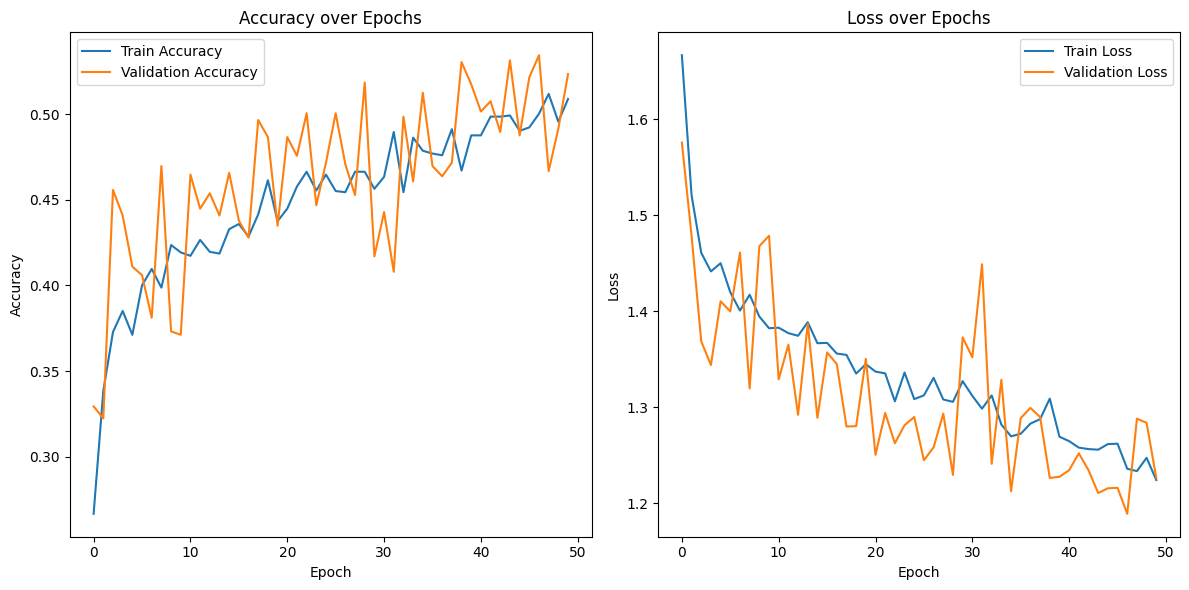

32/32 [==============================] - 34s 1s/step - loss: 12.0672 - accuracy: 0.1968
Test Accuracy: 0.19681908190250397
32/32 [==============================] - 36s 1s/step


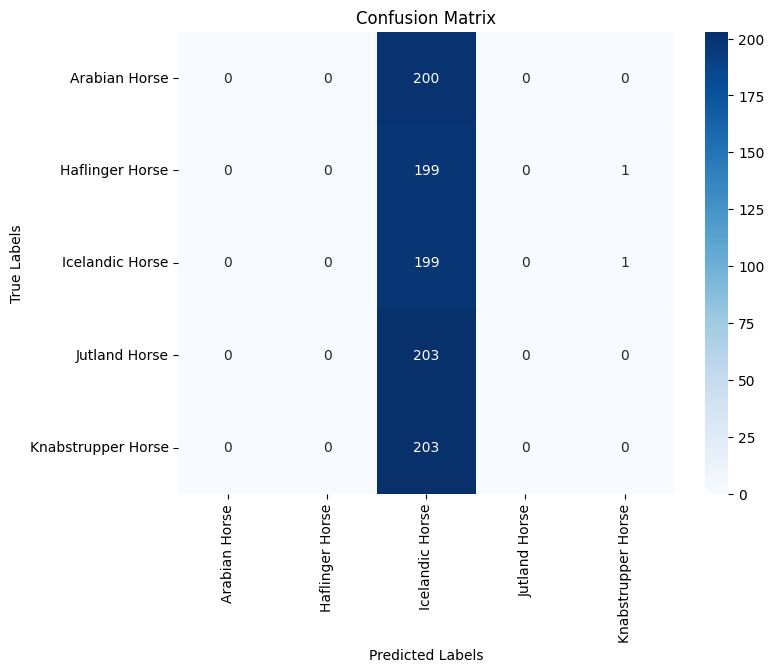

                    precision    recall  f1-score   support

     Arabian Horse       0.00      0.00      0.00       200
   Haflinger Horse       0.00      0.00      0.00       200
   Icelandic Horse       0.20      0.99      0.33       200
     Jutland Horse       0.00      0.00      0.00       203
Knabstrupper Horse       0.00      0.00      0.00       203

          accuracy                           0.20      1006
         macro avg       0.04      0.20      0.07      1006
      weighted avg       0.04      0.20      0.07      1006

Mean Average Precision (mAP): 0.2024955148754452


In [10]:
# Plot training history
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy}")

# Get predictions
y_pred_probabilities = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred_probabilities, axis=1)  # Convert probabilities to class labels

# Confusion Matrix
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded y_true to class labels
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=le.classes_, zero_division=0))

# Calculate Mean Average Precision (mAP)
def compute_map(y_true, y_pred, num_classes):
    average_precisions = []
    for i in range(num_classes):
        true_binary = (y_true == i).astype(int)
        pred_binary = y_pred[:, i]
        if np.sum(true_binary) == 0:
            continue
        average_precision = average_precision_score(true_binary, pred_binary)
        average_precisions.append(average_precision)
    if average_precisions:
        mAP = np.mean(average_precisions)
    else:
        mAP = 0.0
    return mAP

mAP = compute_map(y_true, y_pred_probabilities, len(le.classes_))
print(f"Mean Average Precision (mAP): {mAP}")


5. Conclusion

In [11]:

# Print final evaluation and conclusions
print(f"Training Time: {training_time} seconds")
print(f"Test Accuracy: {test_accuracy}")
print(f"Mean Average Precision (mAP): {mAP}")
print("- The model achieved a test accuracy of {:.2f}%.".format(test_accuracy * 100))


Training Time: 7607.479637622833 seconds
Test Accuracy: 0.19681908190250397
Mean Average Precision (mAP): 0.2024955148754452
- The model achieved a test accuracy of 19.68%.
